In [1]:
from LIMxCMBL.init import *
from LIMxCMBL.noise import *

In [2]:
nbins = 100

In [3]:
# CCAT-prime
zmin = 3.5
zmax = 8.1

Omega_field = 8 * (np.pi/180)**2 #rad^2
Pei = 2.3e4 #Mpc^3 kJy^2 /sr^2 
chimin = ccl.comoving_angular_distance(cosmo, 1/(1+zmin))
chimax = ccl.comoving_angular_distance(cosmo, 1/(1+zmax))

[]

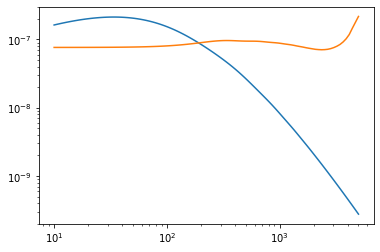

In [4]:
# get CMB lensing component
from LIMxCMBL.kernels import get_f_Kkappa
f_WkD = get_f_Kkappa()

from LIMxCMBL.cross_spectrum import *
ClKK = d_chib_integral(f_WkD, f_WkD) #[Mpc]^2


# beam=1.4, noise=7
from scipy.interpolate import interp1d
N0_ells = np.logspace(1, np.log10(5000), 500)
with open('LIMxCMBL/N0.npy', 'rb') as f:
    N0 = np.load(f)
    
f_N0 = interp1d(x = N0_ells, y = N0)

    
plt.plot(ells, ClKK)
plt.plot(ells, f_N0(ells))
plt.loglog()

In [5]:
# if no high pass IKappa
from  LIMxCMBL.kernels import *
f_KLIM   = get_f_KI()
f_Kkappa = get_f_Kkappa()

f_KLIM_windowed = apply_window(f_K = f_KLIM,
                               chimin = chimin,
                               chimax = chimax)

In [6]:

chi_bin_edges = np.linspace(chimin*(1+1e-8), chimax*(1 - 1e-8), nbins + 1)
chi_bin_centers = (chi_bin_edges[1:] + chi_bin_edges[:-1])/2
dchi_binned = np.mean(np.diff(chi_bin_edges))

In [7]:
Ik_fname = '/scratch/users/delon/LIMxCMBL/IHiKappa/Ik_zmin_%.5f_zmax_%.5f_quad_nbins_%d.npy'%(zmin, zmax, nbins)
I_kappa = np.load(Ik_fname)

In [8]:
external_chis   = chi_bin_centers
from scipy.integrate import simpson, trapezoid, quad_vec

# if no high pass IKappa
from  LIMxCMBL.kernels import *
f_KLIM   = get_f_KI()
f_Kkappa = get_f_Kkappa()

f_KLIM_windowed = apply_window(f_K = f_KLIM,
                               chimin = chimin,
                               chimax = chimax)

_deltas = deltas.reshape(1, -1)

def f_Ik(chi):
    _minus = chi * (1 - _deltas)
    _plus  = chi * (1 + _deltas)

    f_Kpsi = f_KLIM_windowed
    f_Kphi = f_Kkappa

    prefactor = 2 / chi
    kernels = (f_Kpsi(_minus) * f_Kphi(_plus) + f_Kpsi(_plus) * f_Kphi(_minus))
    inner_integral_resampled = f_inner_integral(chi)
    integrand = prefactor*kernels*inner_integral_resampled*deltas_reshaped
    return trapezoid(y=integrand, x=np.log(deltas), axis = -1)

integrand =  lambda chi: (f_Ik(chi)**2 / (Pei/chi**2))[0]
no_filter_SNR2, _ = quad_vec(integrand, chimin, chimax, epsabs = 0.0, epsrel = 1e-3)
no_filter_SNR2 /= (ClKK + f_N0(ells))

In [9]:
Lambda_idx = 0
eHIeHI_oup_fname = '/scratch/users/delon/LIMxCMBL/eHIeHI/mpmath_zmin_%.5f_zmax_%.5f_Lambda_idx_%.d_from_quad_nbins_%d.npy'%(zmin, zmax, Lambda_idx, nbins)

In [10]:
import pickle
with open(eHIeHI_oup_fname+'_results.pkl', 'rb') as f:
    results = pickle.load(f)

In [11]:
eHIeHI = [[0]*(nbins) for _ in range(nbins)]

In [12]:
for i, j, value in results:
        eHIeHI[i][j] = mpm.re(value)

In [13]:
eHIeHI = mpm.matrix(eHIeHI)

In [14]:
ILo_kappa_fname = '/scratch/users/delon/LIMxCMBL/IHiKappa/ILok_zmin_%.5f_zmax_%.5f_idx_%d_quad_nbins_%d.npy'%(zmin, zmax, Lambda_idx, nbins)
ILo_kappa = np.load(ILo_kappa_fname)
IHi_kappa = I_kappa - ILo_kappa

In [15]:
ell_idx = 20
curr_IHi_kappa = mpm.matrix(IHi_kappa[ell_idx])
cov = (ClKK[ell_idx] + f_N0(ells[ell_idx])) * Pei * eHIeHI
x = mpm.cholesky_solve(cov, curr_IHi_kappa)
mpmath_snr2_per_mode = mpm.fdot(x, curr_IHi_kappa)

In [16]:
SNR2_per_mode = {}
eHIeHI_oup_fname = '/scratch/users/delon/LIMxCMBL/eHIeHI/mpmath_zmin_%.5f_zmax_%.5f_Lambda_idx_%.d_from_quad_nbins_%d.npy'%(zmin, zmax, Lambda_idx, nbins)
eHIeHI_binned = np.load(eHIeHI_oup_fname)

cov = np.einsum('i, jk->ijk', (ClKK + f_N0(ells)),  Pei * eHIeHI_binned)
cov = cov.astype(np.float64)
cov = cov
Lambda = Lambdas[Lambda_idx]
SNR2_per_mode[Lambda] = np.zeros_like(ells)
for ell_idx in range(len(ells)):
    L = np.linalg.cholesky(cov[ell_idx])
    y = np.linalg.solve(L, IHi_kappa[ell_idx])
    x = np.linalg.solve(L.T, y)
    SNR2_per_mode[Lambda][ell_idx] = np.dot(IHi_kappa[ell_idx], x)

In [17]:
print((SNR2_per_mode[Lambda][0] - mpmath_snr2_per_mode) / mpmath_snr2_per_mode)

-0.633175773980471164966586839296822
